#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import *

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
import pandas as pd
from IPython.display import display  # Jupyter Notebook에서 이쁘게 출력할 수 있도록 도와주는 display

# 데이터 파일 경로
data_file = r'C:\Users\syj04\Code\2024_aix_final\rawfiles\data01_train.csv'
feature_file = r'C:\Users\syj04\Code\2024_aix_final\rawfiles\features.csv'

# 데이터 불러오기
data = pd.read_csv(data_file, delimiter=',')  # 필요한 경우 delimiter 수정
features = pd.read_csv(feature_file)

# 데이터 확인
print("Data shape:", data.shape)
print("Features shape:", features.shape)

# Jupyter Notebook에서 이쁘게 출력
display(data.head())
display(features.head())


Data shape: (5881, 563)
Features shape: (561, 4)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


Accuracy on validation set: 0.0000


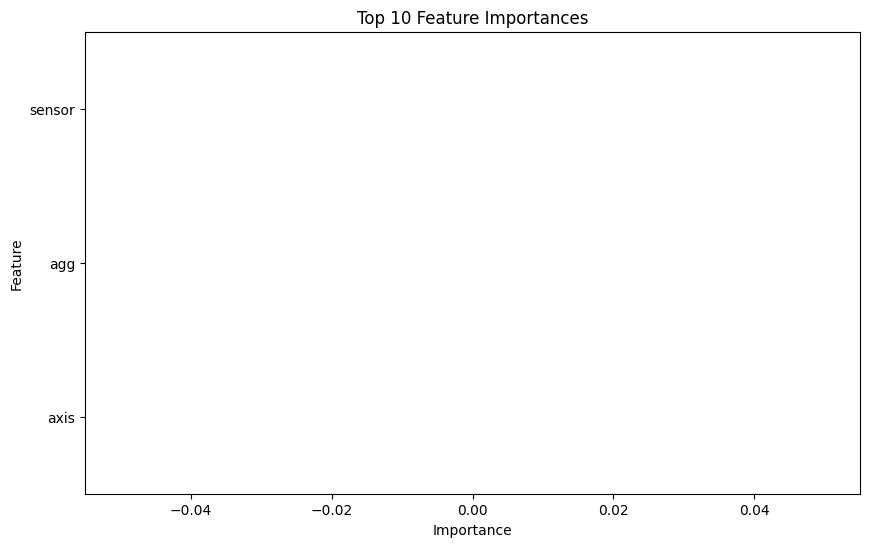

  Feature  Importance
0  sensor         0.0
1     agg         0.0
2    axis         0.0


In [12]:
from sklearn.preprocessing import LabelEncoder

# 타겟 변수 설정 (여기서는 예시로 'feature_name'을 타겟으로 사용)
X = features.drop(['feature_name'], axis=1)  # 'feature_name'을 제외한 나머지 칼럼들
y = features['feature_name']  # 타겟 변수 (feature_name)

# 1. y (타겟 변수)가 문자열이라면 LabelEncoder로 변환
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 2. X (피처 변수)에서 문자열이 포함된 칼럼을 처리
# 만약 X에 문자열 칼럼이 있다면, 이를 숫자로 변환
X = X.apply(pd.to_numeric, errors='coerce')  # 오류가 발생하는 값은 NaN으로 처리

# NaN값을 처리하는 방법 (삭제 혹은 평균 등으로 채우기)
X = X.fillna(X.mean())  # NaN값을 각 칼럼의 평균으로 대체

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 초기화 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 예측
pred = model.predict(X_val)

# 예측 성능 평가
accuracy = accuracy_score(y_val, pred)
print(f"Accuracy on validation set: {accuracy:.4f}")

# 피처 중요도 출력
feature_importances = model.feature_importances_

# 피처 중요도를 시각화 (상위 10개 중요 피처)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[:10], y=X.columns[:10])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 피처 중요도 저장 (fi_analysis.csv 파일로 저장)
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# 상위 중요 피처들 출력
print(importances_df.head(10))

# 피처 중요도를 fi_analysis.csv 파일로 저장
importances_df.to_csv(r'C:\Users\syj04\Code\2024_aix_final\rawfiles\fi_analysis.csv', index=False)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기 (data 로 진행)


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.
    - 데이터의 단변량 그래프를 그려서 데이터의 단변량 분석을 해 봅니다.

In [4]:
#전체 데이터의 행,열 개수 확인
print("전체 데이터의 행과 열 개수:", data.shape)

전체 데이터의 행과 열 개수: (5881, 563)


In [104]:
#전체 데이터의 상위 5개 행 확인
print("\n전체 데이터의 상위 5개 행:")
print(data.head())


전체 데이터의 상위 5개 행:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X 

In [105]:
#전체 데이터의 수치형 변수 분포 확인
print("\n전체 데이터의 기초 통계량 (수치형 변수):")
print(data.describe())


전체 데이터의 기초 통계량 (수치형 변수):
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        5881.000000        5881.000000        5881.000000   
mean            0.274811          -0.017799          -0.109396   
std             0.067614           0.039422           0.058373   
min            -0.503823          -0.684893          -1.000000   
25%             0.262919          -0.024877          -0.121051   
50%             0.277154          -0.017221          -0.108781   
75%             0.288526          -0.010920          -0.098163   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       5881.000000       5881.000000       5881.000000       5881.000000   
mean          -0.603138         -0.509815         -0.604058         -0.628151   
std            0.448807          0.501815          0.417319          0.424345   
min           -1.000000         -0.999844         -0.99

In [106]:
#전체 데이터의 모든 변수 확인
print("\n전체 데이터의 모든 변수:")
print(data.info())


전체 데이터의 모든 변수:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 564 entries, tBodyAcc-mean()-X to is_dynamic
dtypes: float64(561), int64(2), object(1)
memory usage: 25.3+ MB
None


C:\Users\syj04\AppData\Local\Temp\ipykernel_4144\3310392401.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['tBodyAcc-mean()-X'], shade=True)
C:\Users\syj04\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\syj04\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\syj04\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\syj04\AppData\Local\P

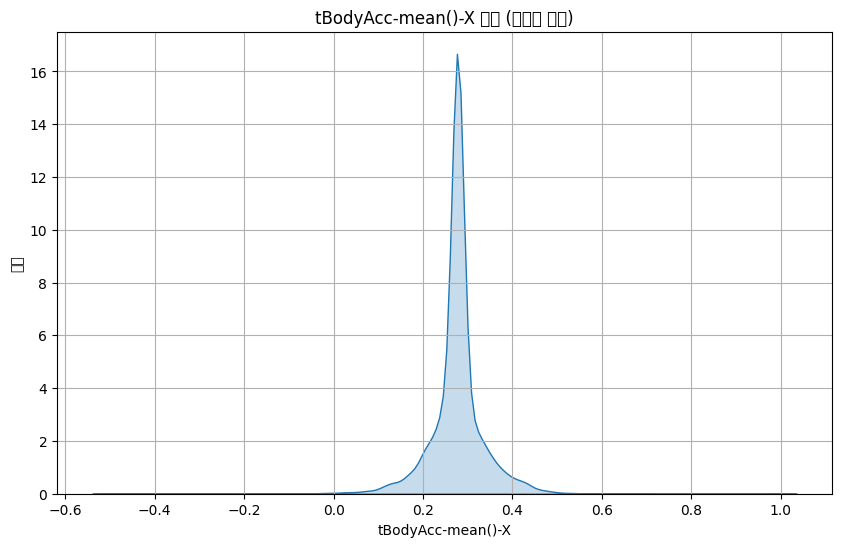

In [107]:
# kde로 tBodyAcc-mean()-X 분포 확인하기 (단변량 분석) - 예제 일뿐 다양한 방법과 다양한 변수로 단변량 그래프를 그려보세요.
# # kde로 tBodyAcc-mean()-X 분포 확인하기 (단변량 분석)
if 'tBodyAcc-mean()-X' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data['tBodyAcc-mean()-X'], shade=True)
    plt.title('tBodyAcc-mean()-X 분포 (단변량 분석)')
    plt.xlabel('tBodyAcc-mean()-X')
    plt.ylabel('밀도')
    plt.grid()
    plt.show()
else:
    print("'tBodyAcc-mean()-X' 컬럼이 데이터에 존재하지 않습니다.")


In [108]:
# 전체 데이터의 이변량 분석 (corr)
num_columns = data.select_dtypes(include=['number'])

correlation_matrix = num_columns.corr()

print("\n전체 데이터의 상관계수:")
print(correlation_matrix)


전체 데이터의 상관계수:
                      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
tBodyAcc-mean()-X              1.000000           0.203297          -0.266383   
tBodyAcc-mean()-Y              0.203297           1.000000          -0.145709   
tBodyAcc-mean()-Z             -0.266383          -0.145709           1.000000   
tBodyAcc-std()-X               0.012067          -0.049467          -0.024839   
tBodyAcc-std()-Y              -0.018489          -0.052489          -0.017613   
...                                 ...                ...                ...   
angle(X,gravityMean)          -0.027010           0.000039           0.007045   
angle(Y,gravityMean)           0.028177           0.002376          -0.017900   
angle(Z,gravityMean)           0.019025          -0.022329          -0.019169   
subject                        0.027597           0.006299          -0.000459   
is_dynamic                     0.007722          -0.055830          -0.042990   

            

In [109]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 경로 설정 (Windows 기본 폰트: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 한글 폰트 적용
plt.rc('font', family=font_prop.get_name())
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# Seaborn 스타일 재설정 (옵션)
sns.set(font=font_prop.get_name())

In [ ]:
# # 이변량 시각화 (변수를 줄여서 분석)
# 상관계수 히트맵
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('상관계수 히트맵')
plt.show()

# 상관이 높은 상위 변수 2~3쌍 선택해 시각화
# 예시: 가장 상관이 높은 변수 쌍 자동 선택
correlated_pairs = correlation_matrix.unstack().sort_values(ascending=False)
correlated_pairs = correlated_pairs[correlated_pairs < 1.0]  # 자기 자신 제외
top_pairs = correlated_pairs.head(3).index  # 상위 3쌍

# 상위 상관 변수들 간의 산점도 그래프
for x, y in top_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[x], y=data[y])
    plt.title(f'{x} vs {y} (산점도)')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.show()

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# 'Activity' 열 단변량 분석
# 범주의 종류 확인
categories = data['Activity'].unique()
print("범주의 종류:", categories)

# 범주별 빈도수 및 비율 계산
value_counts = data['Activity'].value_counts()
value_ratios = data['Activity'].value_counts(normalize=True) * 100

print("\n범주별 빈도수:")
print(value_counts)

print("\n범주별 비율 (%):")
print(value_ratios)

# 범주별 빈도수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
plt.title('Activity 범주별 빈도수')
plt.xlabel('Activity')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 범주별 비율 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=value_ratios.index, y=value_ratios.values, palette="viridis")
plt.title('Activity 범주별 비율 (%)')
plt.xlabel('Activity')
plt.ylabel('비율 (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
sensor_unique_values = features['sensor'].unique()
print("\n'sensor' 변수의 고유 값:")
print(sensor_unique_values)

In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
agg_unique_values = features['agg'].unique()
print("\n'agg' 변수의 고유 값:")
print(agg_unique_values)

In [ ]:
#센서 그룹 데이터의 'axis'변수의 값 확인
axis_unique_values = features['axis'].unique()
print("\n'axis' 변수의 고유 값:")
print(axis_unique_values)

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [91]:
# 데이터 분할을 위한 전처리
target = 'Activity'
x = data.drop(target, axis=1)
y = data[target]

# 2. 훈련 데이터와 검증 데이터로 분할 (30%는 검증 데이터)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

In [95]:
# 3. 모델 정의 및 학습
model = RandomForestClassifier()
model.fit(x_train, y_train)

# 4. 예측 및 평가
pred = model.predict(x_val)
print('accuracy :', accuracy_score(y_val, pred))
print('=' * 60)
print(confusion_matrix(y_val, pred))
print('=' * 60)
print(classification_report(y_val, pred))

accuracy : 0.9756373937677054
[[334   0   0   0   0   0]
 [  0 301   9   0   0   0]
 [  0  15 298   0   0   0]
 [  0   0   0 285   4   3]
 [  0   0   0   2 234   3]
 [  0   0   0   1   6 270]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       334
           SITTING       0.95      0.97      0.96       310
          STANDING       0.97      0.95      0.96       313
           WALKING       0.99      0.98      0.98       292
WALKING_DOWNSTAIRS       0.96      0.98      0.97       239
  WALKING_UPSTAIRS       0.98      0.97      0.98       277

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



In [96]:
# 5. 전체 피처 중요도 추출
feature_importances = model.feature_importances_

# 6. 변수 중요도 시각화 함수 정의
def plot_feature_importance(importances, feature_names, top_n=10):
    importance_df = pd.DataFrame({
        'feature_name': feature_names,
        'importance': importances
    })
    

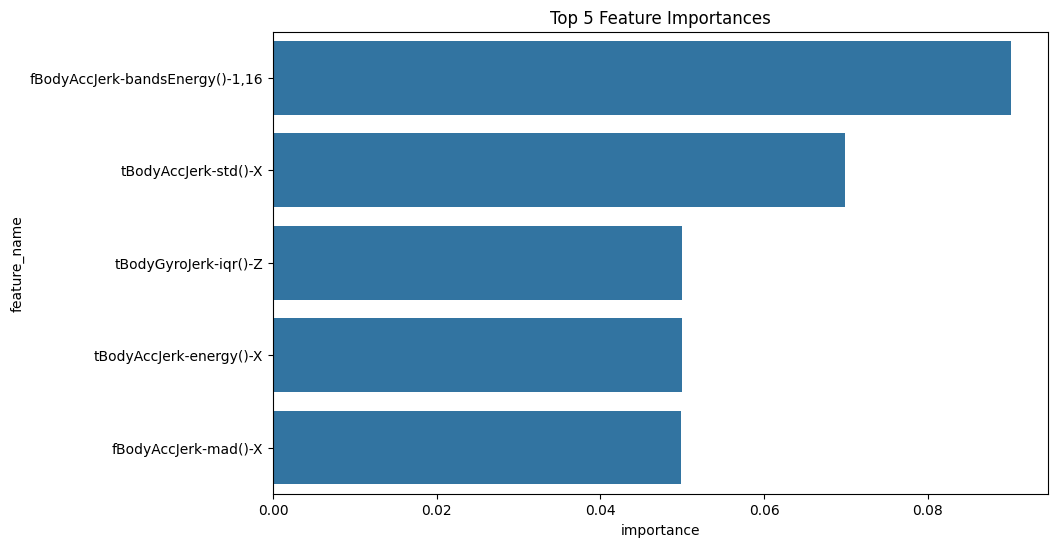

In [99]:
 # 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='importance', ascending=False)
    
    # 상위 top_n개 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature_name', data=importance_df.head(top_n))
plt.title(f"Top {top_n} Feature Importances")
plt.show()

In [100]:
# 7. 중요도 시각화
plot_feature_importance(feature_importances, list(x_train.columns), top_n=10)

# 8. 피처 중요도 데이터프레임 생성
fi_df = pd.DataFrame({
    'feature_name': x_train.columns,  # 피처 이름
    'fi_all': feature_importances     # 전체 중요도
})

In [101]:
# 9. fi_analysis.csv로 저장
fi_df.to_csv('fi_analysis.csv', index=False)
print("Feature importance saved to fi_analysis.csv")

Feature importance saved to fi_analysis.csv


#### 2) 모델링

In [102]:
# 각 행동별로 중요도 추출 함수 정의
def get_feature_importance_for_activity(activity):
    y_activity = (y == activity).astype(int)  # 해당 활동이면 1, 아니면 0

    # 훈련 데이터와 타겟 데이터 분할
    X_train, _, y_train, _ = train_test_split(x, y_activity, test_size=0.3, random_state=42)
    
    # 모델 학습
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 중요도 추출
    feature_importances = rf_model.feature_importances_

    # 중요도를 데이터프레임으로 반환
    fi_df = pd.DataFrame({
        'feature_name': x.columns,
        'feature_importance': feature_importances
    })
    return fi_df

In [ ]:
# 10. 각 활동에 대해 feature importance 계산
fi_dynamic = get_feature_importance_for_activity('WALKING')  # 예시로 WALKING에 대해 계산
fi_standing = get_feature_importance_for_activity('STANDING')
fi_sitting = get_feature_importance_for_activity('SITTING')
fi_laying = get_feature_importance_for_activity('LAYING')
fi_walking_up = get_feature_importance_for_activity('WALKING_UPSTAIRS')
fi_walking_down = get_feature_importance_for_activity('WALKING_DOWNSTAIRS')

# 11. fi_analysis.csv 파일 불러오기 (없다면 새로 생성)
fi_analysis = pd.read_csv('fi_analysis.csv')

# 12. 각 행동별 중요도 컬럼을 fi_analysis에 추가
fi_analysis['fi_dynamic'] = fi_dynamic['feature_importance']
fi_analysis['fi_standing'] = fi_standing['feature_importance']
fi_analysis['fi_sitting'] = fi_sitting['feature_importance']
fi_analysis['fi_laying'] = fi_laying['feature_importance']
fi_analysis['fi_walking_up'] = fi_walking_up['feature_importance']
fi_analysis['fi_walking_down'] = fi_walking_down['feature_importance']

# 13. 전체 활동에 대한 중요도 계산 (모든 행동을 포함한 피처 중요도)
fi_all = get_feature_importance_for_activity('ALL')  # 'ALL'은 모든 활동을 포함하는 경우
fi_analysis['fi_all'] = fi_all['feature_importance']

In [ ]:
# 14. 최종 결과를 fi_analysis_with_all_importances.csv로 저장
fi_analysis.to_csv('fi_analysis_with_all_importances.csv', index=False)
print("Feature importance saved to fi_analysis_with_all_importances.csv")

#### 3) 변수 중요도 추출

In [ ]:
# 변수 중요도 추출
#r0 = plot_feature_importance(model.feature_importances_, list(x_train), False)
#r0

In [67]:
# 9. fi_analysis.csv로 저장
fi_df.to_csv('fi_analysis.csv', index=False)
print("Feature importance saved to fi_analysis.csv")

# 각 행동별로 중요도 추출 함수 정의
def get_feature_importance_for_activity(activity):
    y_activity = (y == activity).astype(int)  # 해당 활동이면 1, 아니면 0

    # 훈련 데이터와 타겟 데이터 분할
    X_train, _, y_train, _ = train_test_split(x, y_activity, test_size=0.3, random_state=42)
    
    # 모델 학습
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 중요도 추출
    feature_importances = rf_model.feature_importances_

    # 중요도를 데이터프레임으로 반환
    fi_df = pd.DataFrame({
        'feature_name': x.columns,
        'feature_importance': feature_importances
    })
    return fi_df

Feature importance saved to fi_analysis.csv


In [69]:
# 10. 각 활동에 대해 feature importance 계산
fi_dynamic = get_feature_importance_for_activity('WALKING')  # 예시로 WALKING에 대해 계산
fi_standing = get_feature_importance_for_activity('STANDING')
fi_sitting = get_feature_importance_for_activity('SITTING')
fi_laying = get_feature_importance_for_activity('LAYING')
fi_walking_up = get_feature_importance_for_activity('WALKING_UPSTAIRS')
fi_walking_down = get_feature_importance_for_activity('WALKING_DOWNSTAIRS')

# 11. fi_analysis.csv 파일 불러오기 (없다면 새로 생성)
fi_analysis = pd.read_csv('fi_analysis.csv') #if 'fi_analysis.csv' in os.listdir() else pd.DataFrame()

# 12. 각 행동별 중요도 컬럼을 fi_analysis에 추가
fi_analysis['fi_dynamic'] = fi_dynamic['feature_importance']
fi_analysis['fi_standing'] = fi_standing['feature_importance']
fi_analysis['fi_sitting'] = fi_sitting['feature_importance']
fi_analysis['fi_laying'] = fi_laying['feature_importance']
fi_analysis['fi_walking_up'] = fi_walking_up['feature_importance']
fi_analysis['fi_walking_down'] = fi_walking_down['feature_importance']

# 13. 전체 활동에 대한 중요도 계산 (모든 행동을 포함한 피처 중요도)
fi_all = get_feature_importance_for_activity('ALL')  # 'ALL'은 모든 활동을 포함하는 경우
fi_analysis['fi_all'] = fi_all['feature_importance']

# 14. 최종 결과를 fi_analysis_with_all_importances.csv로 저장
fi_analysis.to_csv('fi_analysis_with_all_importances.csv', index=False)
print("Feature importance saved to fi_analysis_with_all_importances.csv")

Feature importance saved to fi_analysis_with_all_importances.csv


#### 4) feature importance 데이터 가져오기
위 모델링을 통해 생성한 feature별 중요도 데이터를 제공해 드립니다. random forest 모델링이 너무 어렵다면, 해당 데이터를 활용해도 무방합니다.

In [25]:
#fi_analysis 데이터 불러오기
data_path = "./fi_analysis.csv"
fi_analysis = pd.read_csv(data_path)
r0 = fi_analysis.filter(items=['feature_name','fi_all'])
r0.rename(columns={'fi_all':'feature_importance'}, inplace=True)
r0.sort_values(by=['feature_importance'], axis=0, ascending=False)

,feature_name,feature_importance
214,tGravityAccMag-std(),0.055114
9,tBodyAcc-max()-X,0.054646
502,fBodyAccMag-mean(),0.043094
504,fBodyAccMag-mad(),0.042124
281,fBodyAcc-energy()-X,0.041305
...,...,...
195,"tBodyGyroJerk-arCoeff()-Z,3",0.000015
356,fBodyAccJerk-min()-X,0.000014
238,tBodyAccJerkMag-arCoeff()4,0.000013
554,"angle(tBodyAccMean,gravity)",0.000007


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [70]:
# 중요도 상위 5
r0.head(5)

,feature_name,feature_importance
0,tBodyAcc-mean()-X,0.000079
1,tBodyAcc-mean()-Y,0.000364
2,tBodyAcc-mean()-Z,0.000326
3,tBodyAcc-std()-X,0.020387
4,tBodyAcc-std()-Y,0.001245


In [71]:
# 중요도 하위 5
r0.tail(5)

,feature_name,feature_importance
557,"angle(tBodyGyroJerkMean,gravityMean)",0.000062
558,"angle(X,gravityMean)",0.002521
559,"angle(Y,gravityMean)",0.005086
560,"angle(Z,gravityMean)",0.001278
561,subject,0.000832


<Axes: xlabel='tBodyAcc-mean()-X', ylabel='Density'>

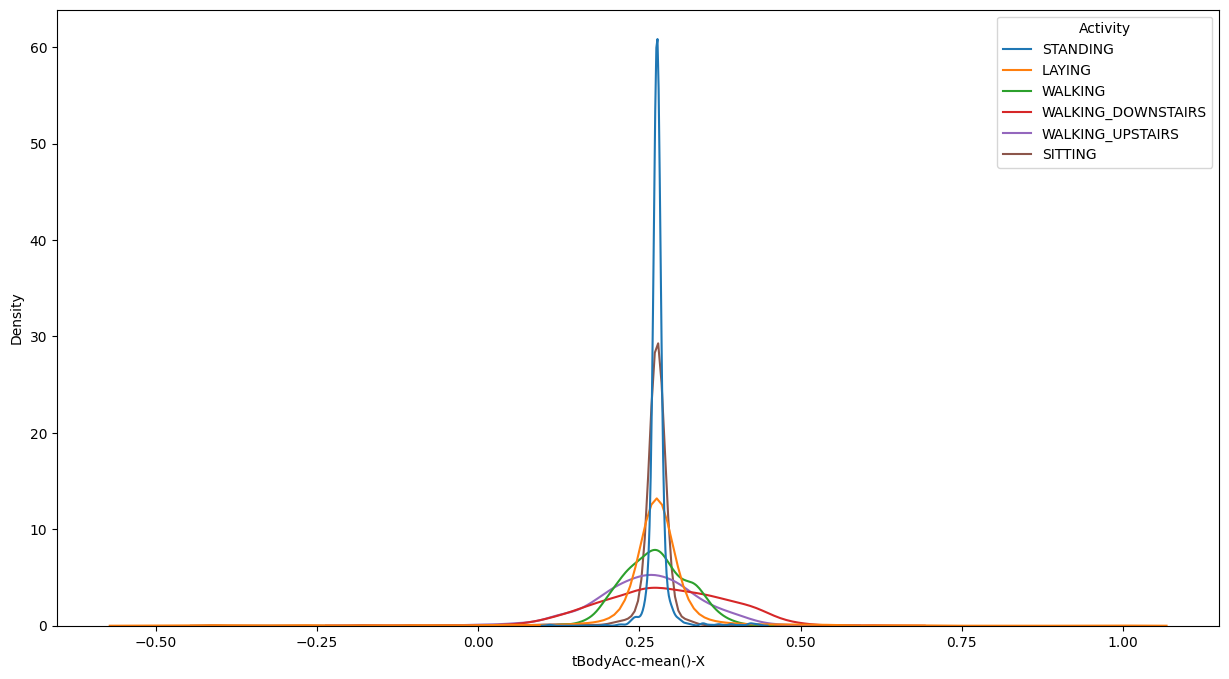

In [72]:
# 상위 1위 'tBodyAcc-mean()-X'
var = 'tBodyAcc-mean()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data=data, hue =target, common_norm = False)

<Axes: xlabel='subject', ylabel='Density'>

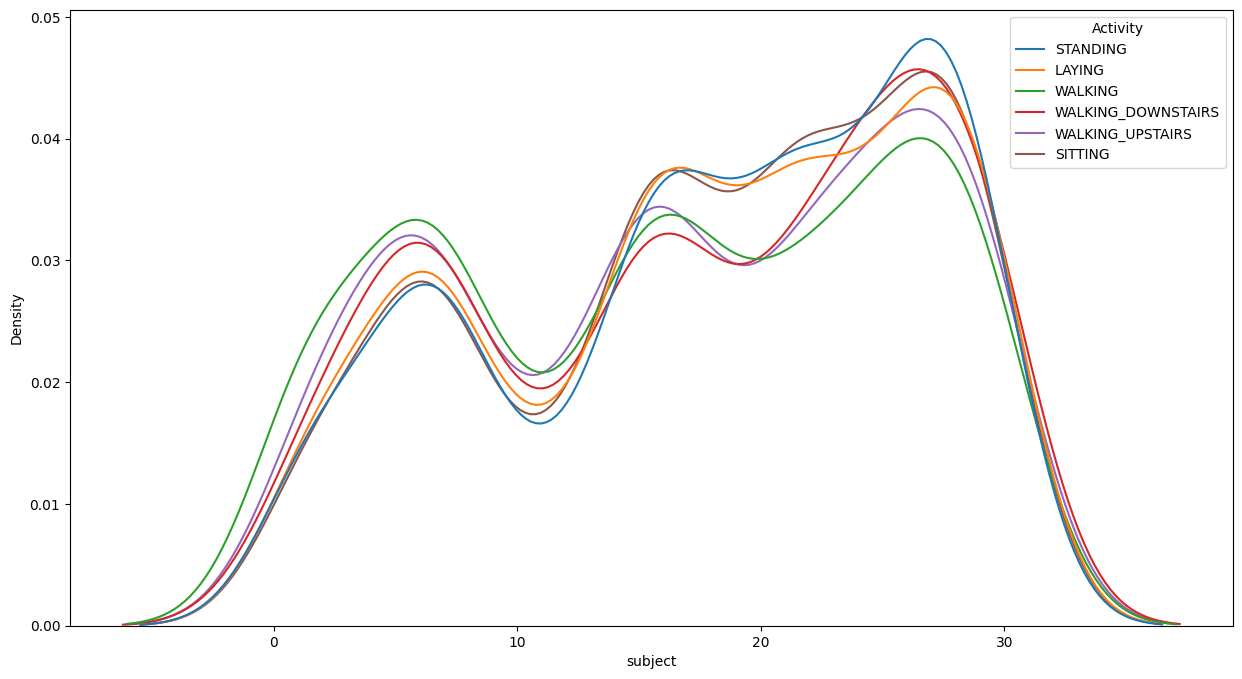

In [73]:
# 하위 1위 'subject'
var = 'subject'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data=data, hue =target, common_norm = False)

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


#### 1) 결과 merge

In [74]:
# features.csv 파일을 불러오기
features_file = r'C:\Users\syj04\Code\2024_aix_final\rawfiles\features.csv'
features_df = pd.read_csv(features_file)

# fi_analysis.csv 파일을 불러오기
fi_analysis_file = 'fi_analysis.csv'
fi_df = pd.read_csv(fi_analysis_file)

# 두 데이터프레임을 feature_name을 기준으로 병합
merged_df = pd.merge(fi_df, features_df, left_on='feature_name', right_on='feature_name', how='left')

# 병합된 데이터 확인
print(merged_df.head())


        feature_name    fi_all    sensor     agg axis
0  tBodyAcc-mean()-X  0.000224  tBodyAcc  mean()    X
1  tBodyAcc-mean()-Y  0.000239  tBodyAcc  mean()    Y
2  tBodyAcc-mean()-Z  0.000168  tBodyAcc  mean()    Z
3   tBodyAcc-std()-X  0.002046  tBodyAcc   std()    X
4   tBodyAcc-std()-Y  0.000603  tBodyAcc   std()    Y


#### 2) sensor 별 중요도

<Figure size 2000x1000 with 0 Axes>

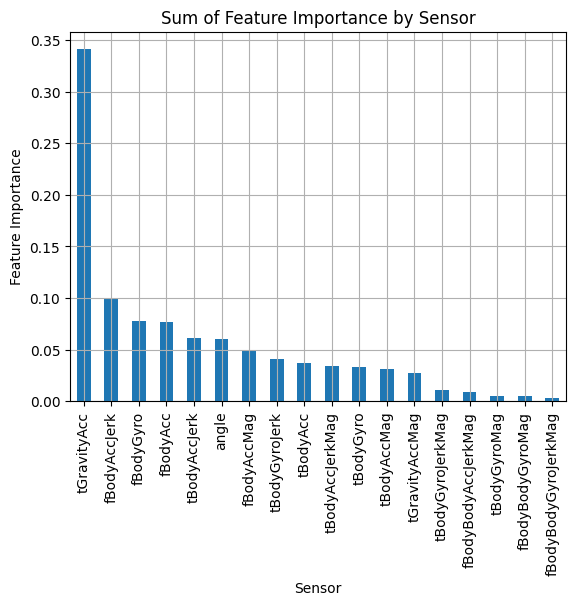

In [75]:
# 'sensor'별 중요도 합계를 계산
sensor_importance = merged_df.groupby('sensor')[['fi_all']].sum().sort_values('fi_all', ascending=False)

# 바 차트로 시각화
plt.figure(figsize=(20, 10))
sensor_importance.plot(kind='bar', legend=False)
plt.title('Sum of Feature Importance by Sensor')
plt.ylabel('Feature Importance')
plt.xlabel('Sensor')
plt.grid(True)
plt.show()

#### 3) sensor + agg 별 중요도

<Figure size 2000x1000 with 0 Axes>

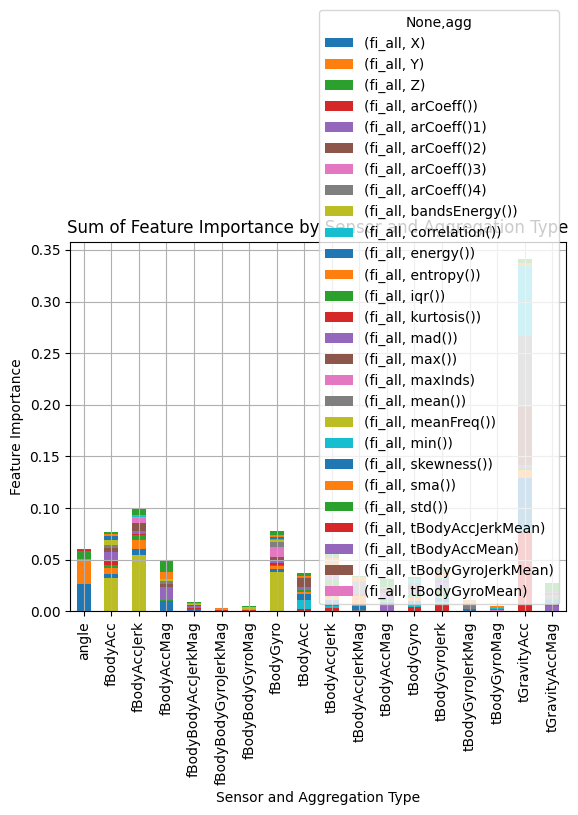

In [76]:
# 'sensor'와 'agg'별 중요도 합계를 계산
sensor_agg_importance = merged_df.groupby(['sensor', 'agg'])[['fi_all']].sum().sort_values('fi_all', ascending=False)

# 바 차트로 시각화
plt.figure(figsize=(20, 10))
sensor_agg_importance.unstack().plot(kind='bar', stacked=True)
plt.title('Sum of Feature Importance by Sensor and Aggregation Type')
plt.ylabel('Feature Importance')
plt.xlabel('Sensor and Aggregation Type')
plt.grid(True)
plt.show()


#### 3-1) sensor 별, agg로 나눠서 분석하기

<Figure size 2000x1000 with 0 Axes>

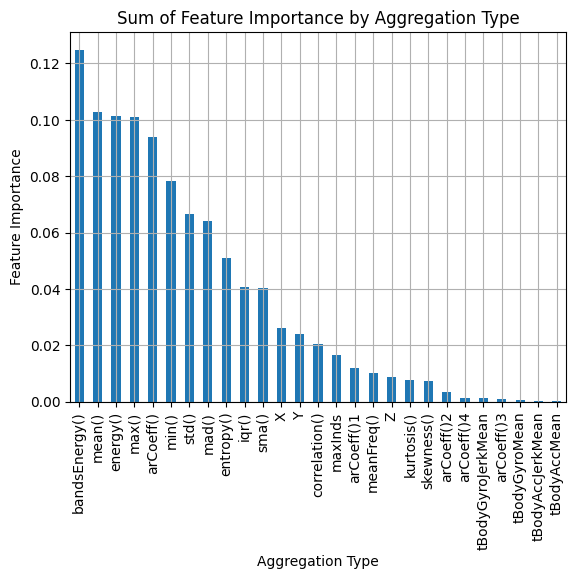

In [77]:
# 'agg'별 중요도 합계 계산
agg_importance = merged_df.groupby('agg')[['fi_all']].sum().sort_values('fi_all', ascending=False)

# 바 차트로 시각화
plt.figure(figsize=(20, 10))
agg_importance.plot(kind='bar', legend=False)
plt.title('Sum of Feature Importance by Aggregation Type')
plt.ylabel('Feature Importance')
plt.xlabel('Aggregation Type')
plt.grid(True)
plt.show()


<Figure size 2000x1000 with 0 Axes>

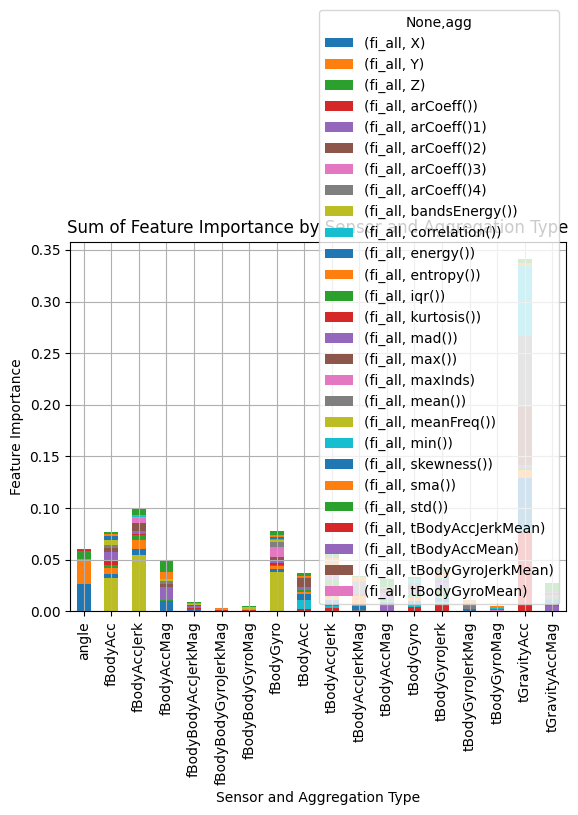

In [78]:
# 'sensor'와 'agg'별 중요도 합계 계산
sensor_agg_importance = merged_df.groupby(['sensor', 'agg'])[['fi_all']].sum().sort_values('fi_all', ascending=False)

# 바 차트로 시각화
plt.figure(figsize=(20, 10))
sensor_agg_importance.unstack().plot(kind='bar', stacked=True)
plt.title('Sum of Feature Importance by Sensor and Aggregation Type')
plt.ylabel('Feature Importance')
plt.xlabel('Sensor and Aggregation Type')
plt.grid(True)
plt.show()


## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가 (옵션)

In [79]:
# is_dynamic 변수 생성
data['is_dynamic'] = data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

# 생성된 is_dynamic 변수 확인
print(data[['Activity', 'is_dynamic']].head())


             Activity  is_dynamic
0            STANDING           0
1              LAYING           0
2            STANDING           0
3             WALKING           1
4  WALKING_DOWNSTAIRS           1


#### 2) 기본모델 생성 (옵션)

In [80]:
# X와 y 정의
x = data.drop(columns=['Activity', 'is_dynamic'])  # 'Activity'와 'is_dynamic'을 제외한 피처들
y = data['is_dynamic']

# 데이터 분할 (훈련 70%, 검증 30%)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

# 랜덤포레스트 모델 생성
model = RandomForestClassifier()

# 학습
model.fit(x_train, y_train)
pred = model.predict(x_val)

# 성능 평가
print('Accuracy:', accuracy_score(y_val, pred))
print('Confusion Matrix:\n', confusion_matrix(y_val, pred))
print('Classification Report:\n', classification_report(y_val, pred))

Accuracy: 1.0
Confusion Matrix:
 [[957   0]
 [  0 808]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       808

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석 (옵션)

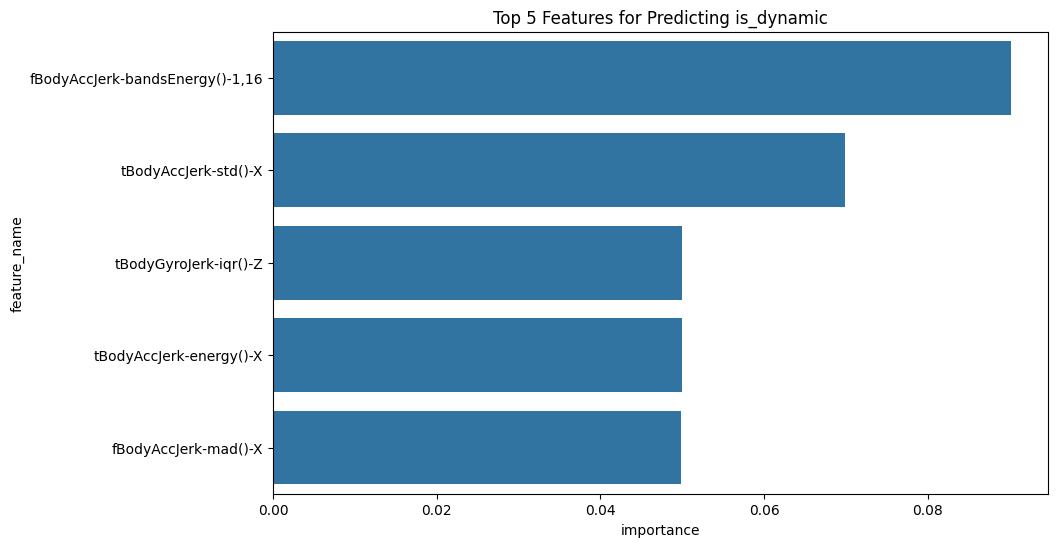

In [81]:
# 변수 중요도 추출
feature_importances = model.feature_importances_

# 변수 이름과 중요도를 데이터프레임으로 만듦
importance_df = pd.DataFrame({
    'feature_name': x_train.columns,
    'importance': feature_importances
})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 상위 5개 변수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature_name', data=importance_df.head(5))
plt.title('Top 5 Features for Predicting is_dynamic')
plt.show()

#### 데이터 가져오기로 1), 2), 3) 대체 가능

In [82]:
# fi_analysis의 컬럼 확인
print(fi_analysis.columns)

Index(['feature_name', 'fi_all', 'fi_dynamic', 'fi_standing', 'fi_sitting',
       'fi_laying', 'fi_walking_up', 'fi_walking_down'],
      dtype='object')


#### 4) feature 그룹별 분석

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.